# Modeling Consumer Activity with a Modified Maxwell–Boltzmann Distribution

This notebook reproduces the main steps of the modeling procedure described in our paper:
"Study of the relationship between individual consumer behavior and macroeconomic trends."

It demonstrates:
1. Preprocessing of banking transaction data  
2. Construction of the consumer activity metric  
3. Fitting of the modified and classical Maxwell–Boltzmann distributions  
4. Evaluation of model quality using statistical metrics  
5. Comparison across datasets and model variants

Data used: 2nd dataset with 25K clients(dataset_2)

Model variants: Modified

### Description of the second data set

The dataset under study is data on 6938421 transactions of 25000 bank clients. The observation period is from 01/05/2017 to 31/12/2018.

An unprepared version of the dataset can be found at [Google Drive.](https://drive.google.com/drive/folders/1PKqYacxA3ZWsRbn8CySrPnXYor_aJFJJ)

Each row corresponds to one client and includes the following columns:
- `client` : Client identifier (discrete numeric).
- `card` : Client's payment card identifier (discrete numeric).
- `date` : Transaction date (continuous numeric, date format).
- `amt` : Amount spent (continuous numeric).
- `mcc` : Merchant category code (discrete numeric).
- `group` : The group the purchase belongs to (categorical). Examples: 'food', 'travel', 'fun'.
- `value` : Basic value category (categorical):
  - `survival`: 'food', 'outfit', 'health', 'dwelling'.
  - `socialization`: 'travel', 'nonfood', 'telecom', 'misc', 'remote'.
  - `self_realization` : 'fun', 'kids', 'beauty', 'charity'.

### Data preprocessing

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import STL

from model import *

In [2]:
selected_dataset = 'dataset_2'

In [3]:
# Downloading data
df = pd.read_csv('../Data/dataset25k.csv')

In [4]:
df.head()

,client,card,date,amt,MCC,group,value
0,1013598,3492659,2018-11-17,100.00,7995.0,fun,self_realization
1,1015701,1579521,2018-05-28,350.00,7995.0,fun,self_realization
2,1012702,3832308,2018-05-05,391.30,5411.0,food,survival
3,1015828,3159486,2018-05-05,499.00,5411.0,food,survival
4,1012216,3417742,2018-05-05,335.48,5411.0,food,survival


In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5507977 entries, 0 to 5507976
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   client  int64         
 1   card    int64         
 2   date    datetime64[ns]
 3   amt     float64       
 4   MCC     float64       
 5   group   object        
 6   value   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 294.2+ MB


In [7]:
# Main statistics
stats = {
    'Mean': df['amt'].mean(),
    'Median': df['amt'].median(),
    'Standard deviation': df['amt'].std(),
    'Min': df['amt'].min(),
    'Max': df['amt'].max(),
    '25% quantile': df['amt'].quantile(0.25),
    '75% quantile': df['amt'].quantile(0.75),
    'Coefficient of variation': df['amt'].std() / df['amt'].mean()
}
print(pd.DataFrame.from_dict(stats, orient='index', columns=['Value']))

                                 Value
Mean                      9.954828e+02
Median                    3.790000e+02
Standard deviation        6.480714e+03
Min                       1.000000e-02
Max                       1.086000e+07
25% quantile              1.690000e+02
75% quantile              9.000000e+02
Coefficient of variation  6.510122e+00


In [8]:
# Inflation consideration
# Loading inflation data
inflation_df = get_inflation_data(selected_dataset)

inflation_df = inflation_df.sort_values(by='Date').reset_index(drop=True)

# calculation accumulated inflation
inflation_df['Inflation, % month'] = (1 + inflation_df['Inflation, % y/y'] / 100) ** (1/12) - 1
inflation_df['Accumulated inflation'] = (1 + inflation_df['Inflation, % month']).cumprod()

base_inflation = inflation_df.loc[0, 'Accumulated inflation']
inflation_df['Adjustment factor'] = inflation_df['Accumulated inflation'] / base_inflation

# Create a full range of dates from min to max
all_dates = pd.date_range(start=inflation_df['Date'].min(), end=inflation_df['Date'].max())
interpolated_inflation = pd.DataFrame({'Date': all_dates})

# Interpolation of adjustment coefficients
interpolated_inflation = interpolated_inflation.merge(inflation_df[['Date', 'Adjustment factor']],on='Date',how='left')
interpolated_inflation['Adjustment factor'] = interpolated_inflation['Adjustment factor'].interpolate(method='linear')

In [9]:
interpolated_inflation['Date'] = pd.to_datetime(interpolated_inflation['Date'])
df = df.merge(interpolated_inflation[['Date', 'Adjustment factor']], left_on='date', right_on='Date', how='left')

df['adjusted_amt'] = df['amt'] / df['Adjustment factor']

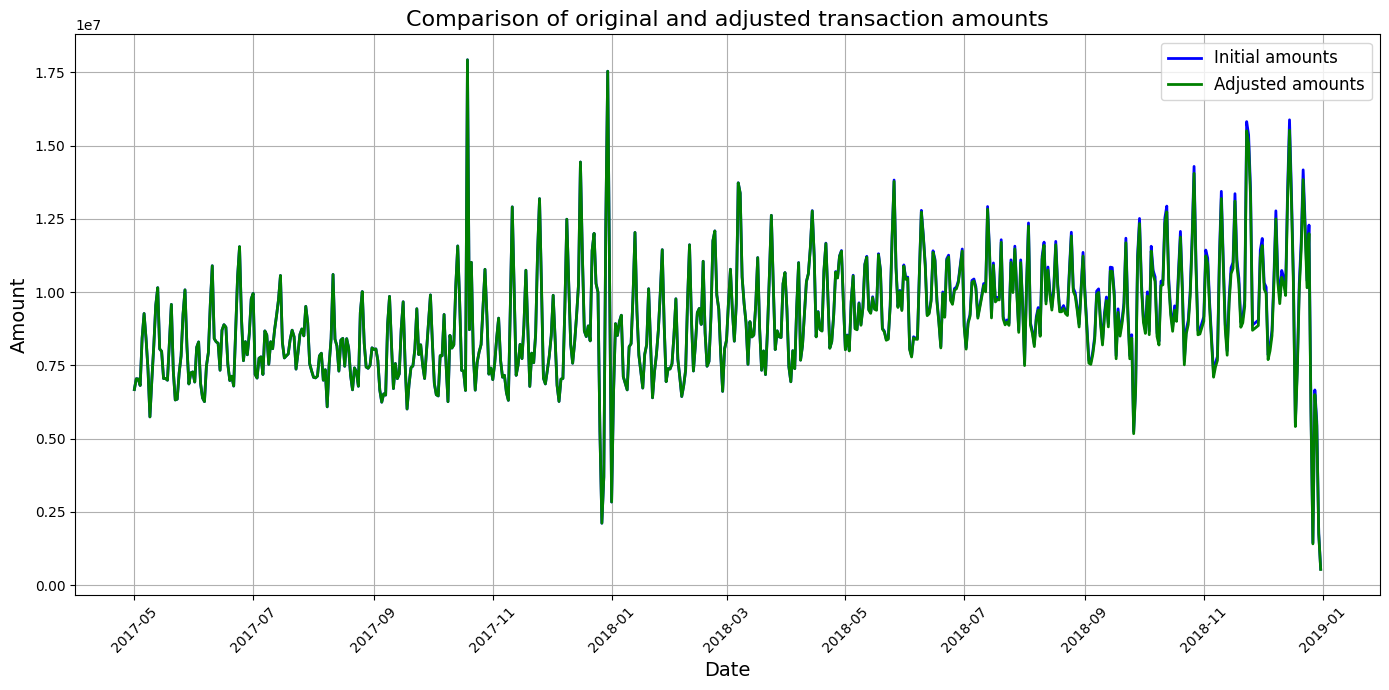

In [10]:
# Comparison of original and adjusted transaction amounts without inflation
original_totals = df.groupby('date')['amt'].sum().reset_index()
adjusted_totals = df.groupby('date')['adjusted_amt'].sum().reset_index()

plt.figure(figsize=(14, 7))

plt.plot(original_totals['date'], original_totals['amt'], label='Initial amounts', color='blue', linewidth=2)
plt.plot(adjusted_totals['date'], adjusted_totals['adjusted_amt'], label='Adjusted amounts', color='green', linewidth=2)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.title('Comparison of original and adjusted transaction amounts', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Daily Aggregate Sum
ts = df.groupby('date')['adjusted_amt'].sum()

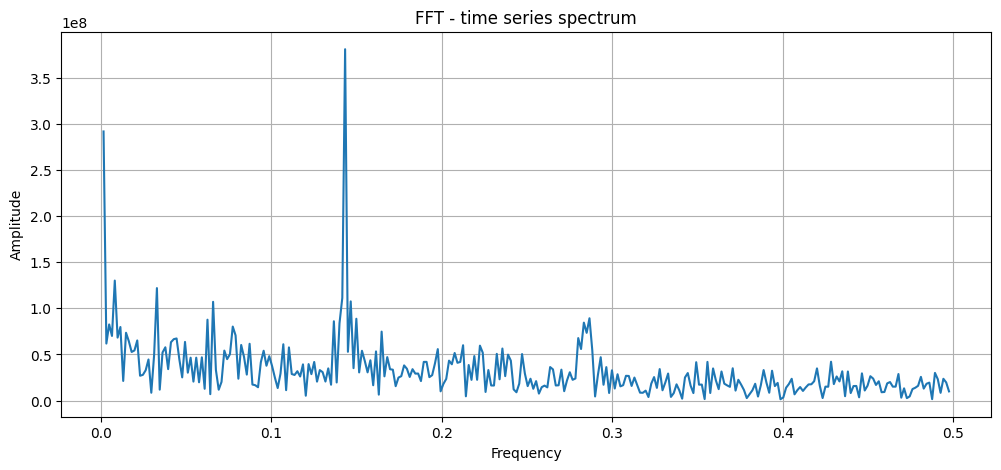

In [12]:
# FFT
n = len(ts)
ts_values = ts.values - np.nanmean(ts.values)
yf = fft(ts_values)
xf = fftfreq(n, d=1)  # d=1 — step in days

plt.figure(figsize=(12, 5))
plt.plot(xf[1:n//2], np.abs(yf[1:n//2]))
plt.title("FFT - time series spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

<Figure size 1200x800 with 0 Axes>

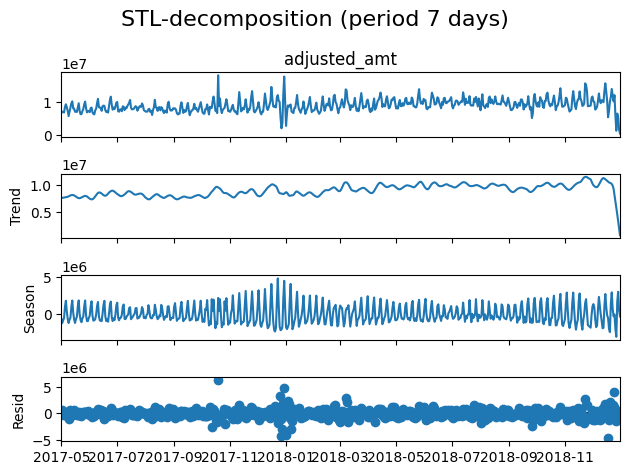

<Figure size 1200x800 with 0 Axes>

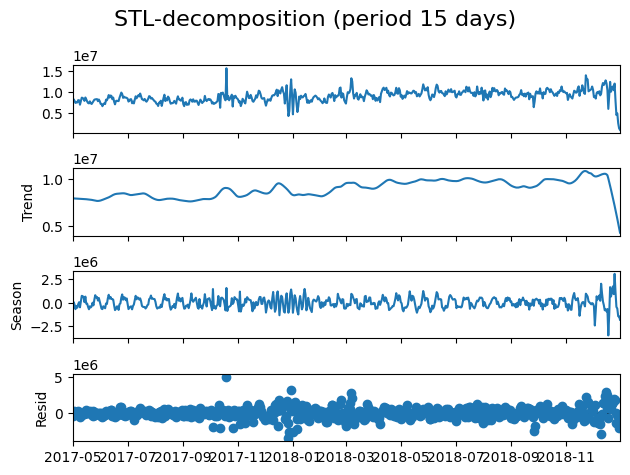

In [13]:
# STL-decomposition
current_ts = ts.copy()

# Sequential removal of seasonality
for i, period in enumerate([7,15]):
    stl = STL(current_ts, period=period)
    res = stl.fit()
    
    # Visualisation
    plt.figure(figsize=(12, 8))
    res.plot()
    plt.suptitle(f"STL-decomposition (period {period} days)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    deseasonalized_ts = current_ts - res.seasonal
    current_ts = deseasonalized_ts

In [14]:
# Combining adjusted amounts with original data
deseasonalized_ts.index = pd.to_datetime(deseasonalized_ts.index)

df['daily_share'] = df.groupby(df['date'].dt.date)['adjusted_amt'].transform(lambda x: x / x.sum())
df = df.merge(deseasonalized_ts.rename('deseasonalized_daily_total'), left_on='date', right_index=True,suffixes=('_left', '_right'))
df['adjusted_amount'] = df['daily_share'] * df['deseasonalized_daily_total']

# Checking the results
print("\nDataFrame with adjusted amounts:")
print(df[['date', 'adjusted_amt', 'adjusted_amount']].head())


DataFrame with adjusted amounts:
        date  adjusted_amt  adjusted_amount
0 2018-11-17     98.107453        82.196568
1 2018-05-28    348.732840       374.797755
2 2018-05-05    390.431852       358.929142
3 2018-05-05    497.892906       457.719504
4 2018-05-05    334.735696       307.726933


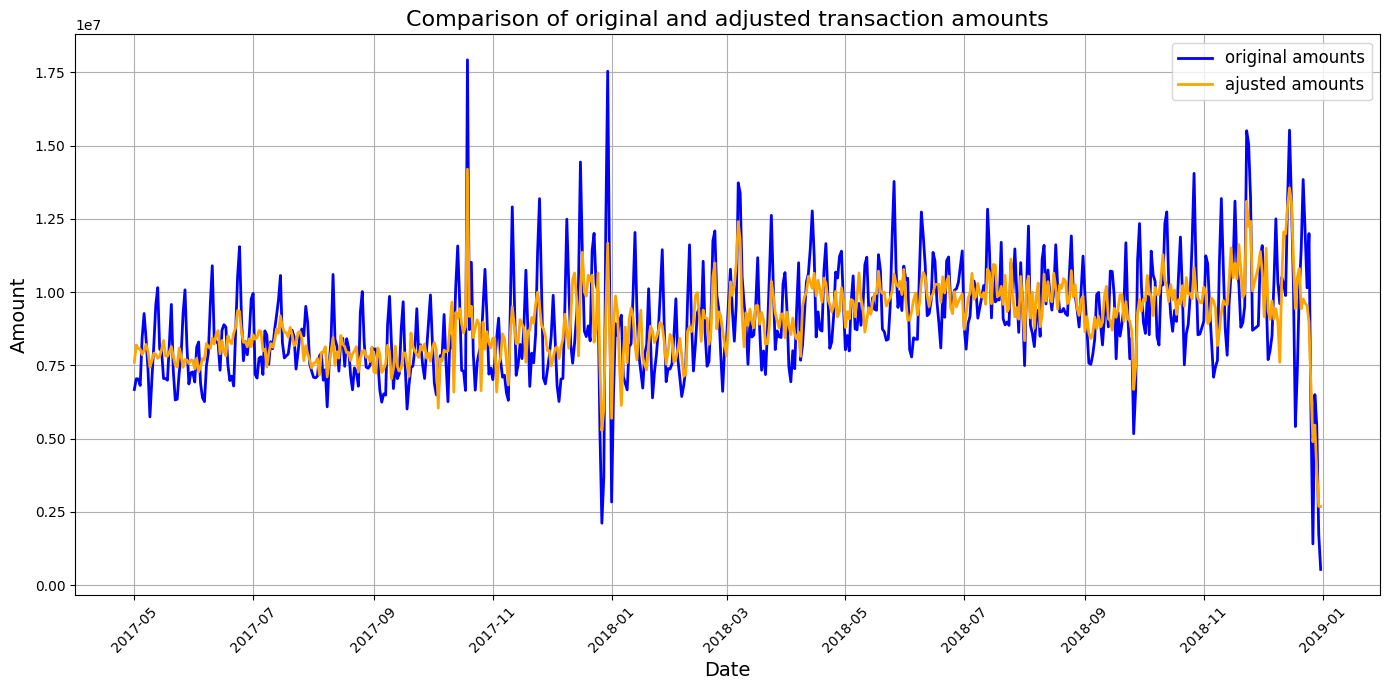

In [15]:
# Plotting a comparison graph
original_totals = df.groupby('date')['adjusted_amt'].sum().reset_index()
corrected_totals = df.groupby('date')['adjusted_amount'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(original_totals['date'], original_totals['adjusted_amt'], label='original amounts', color='blue', linewidth=2)
plt.plot(corrected_totals['date'], corrected_totals['adjusted_amount'], label='ajusted amounts', color='orange', linewidth=2)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.title('Сomparison of original and adjusted transaction amounts', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compute consumer activity metric

In [16]:
# Client state
# Recount log10(amt_adjusted)
df['exp'] = np.log10(df[['adjusted_amount']])

# 2. Preparation of aggregated data
# Group by ['date', 'client', 'value'] and calculate the maximum exp value
individual = (df.groupby(['date', 'client', 'value'])['exp'].max().unstack(level='value', fill_value=0))

print("Client state by day:")
print(individual.head())

Client state by day:
value              self_realization  socialization  survival
date       client                                           
2017-05-01 103             2.600913       0.000000  0.000000
           1035            0.000000       3.781121  0.000000
           1057            0.000000       0.000000  2.856186
           1086            0.000000       0.000000  3.049840
           10051           0.000000       3.074296  2.699962


# Model definition and fitting

In [17]:
individual = individual.reset_index()

In [18]:
individual.head()

value,date,client,self_realization,socialization,survival
0,2017-05-01,103,2.600913,0.000000,0.000000
1,2017-05-01,1035,0.000000,3.781121,0.000000
2,2017-05-01,1057,0.000000,0.000000,2.856186
3,2017-05-01,1086,0.000000,0.000000,3.049840
4,2017-05-01,10051,0.000000,3.074296,2.699962


In [19]:
model_type = 'modified'

In [20]:
alldates=pd.DataFrame({'date':individual['date'].unique()})
individual = individual.set_index(['date', 'client'])

In [21]:
# Modeling results
results = []
for idx, date in enumerate(alldates['date']):
    try:
        results_df = calc_distr_params(individual, date, 'modified')
        if not results_df.empty:
            results.append(results_df)
    except Exception as e:
        print(f"Ошибка при обработке {date}: {e}")

final_results = pd.concat(results, ignore_index=True)

In [22]:
final_results.head()

,date,B,beta,x0,alpha,method,ks_statistic,p_value,wasserstein_distance,rmse
0,2017-05-01,0.100003,0.413796,0.836717,3.815754,mle,0.166667,0.807963,0.013579,0.083715
1,2017-05-01,0.159585,0.659432,1.411289,2.916381,mls,0.266667,0.239073,0.008992,0.008183
2,2017-05-02,0.000001,0.423693,0.905727,3.255159,mle,0.200000,0.594071,0.008511,0.056001
3,2017-05-02,0.132927,0.622437,1.145520,3.445517,mls,0.333333,0.070888,0.005205,0.006071
4,2017-05-03,0.000001,0.439123,0.985109,3.071396,mle,0.233333,0.392945,0.007833,0.057106


In [23]:
final_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1214 non-null   datetime64[ns]
 1   B                     1214 non-null   float64       
 2   beta                  1214 non-null   float64       
 3   x0                    1214 non-null   float64       
 4   alpha                 1214 non-null   float64       
 5   method                1214 non-null   object        
 6   ks_statistic          1214 non-null   float64       
 7   p_value               1214 non-null   float64       
 8   wasserstein_distance  1214 non-null   float64       
 9   rmse                  1214 non-null   float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 95.0+ KB


In [24]:
summary = analyze_results(final_results)

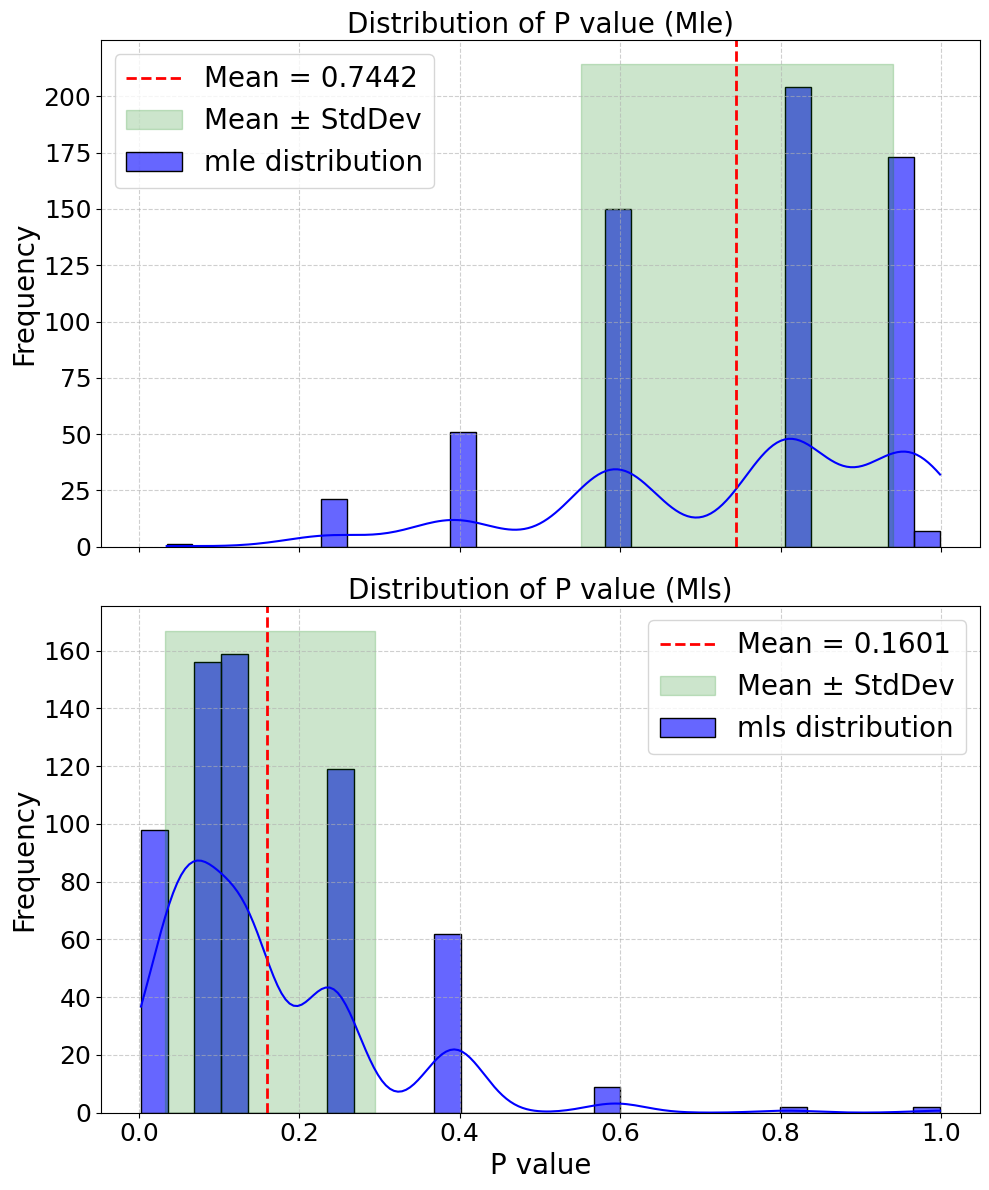

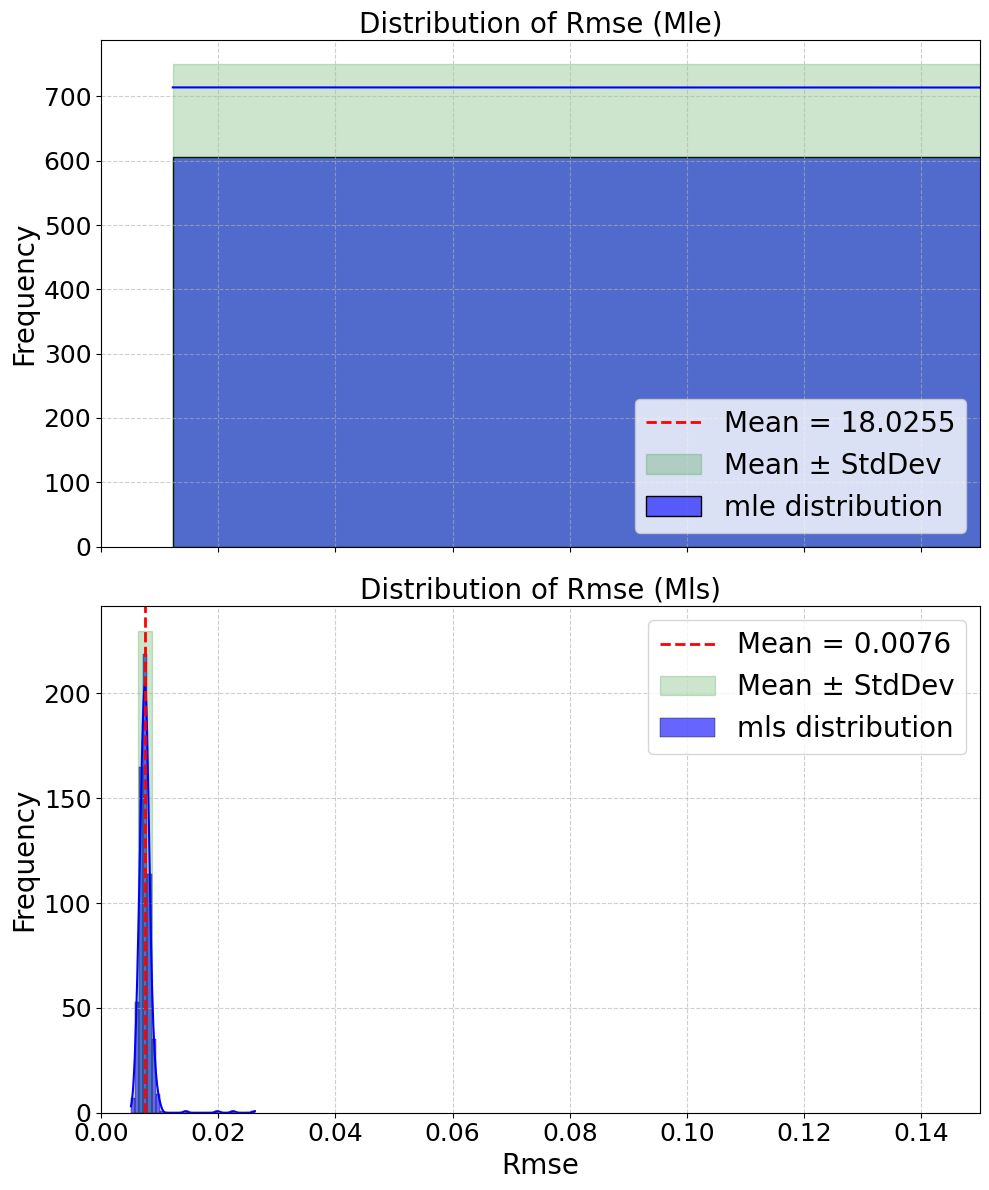

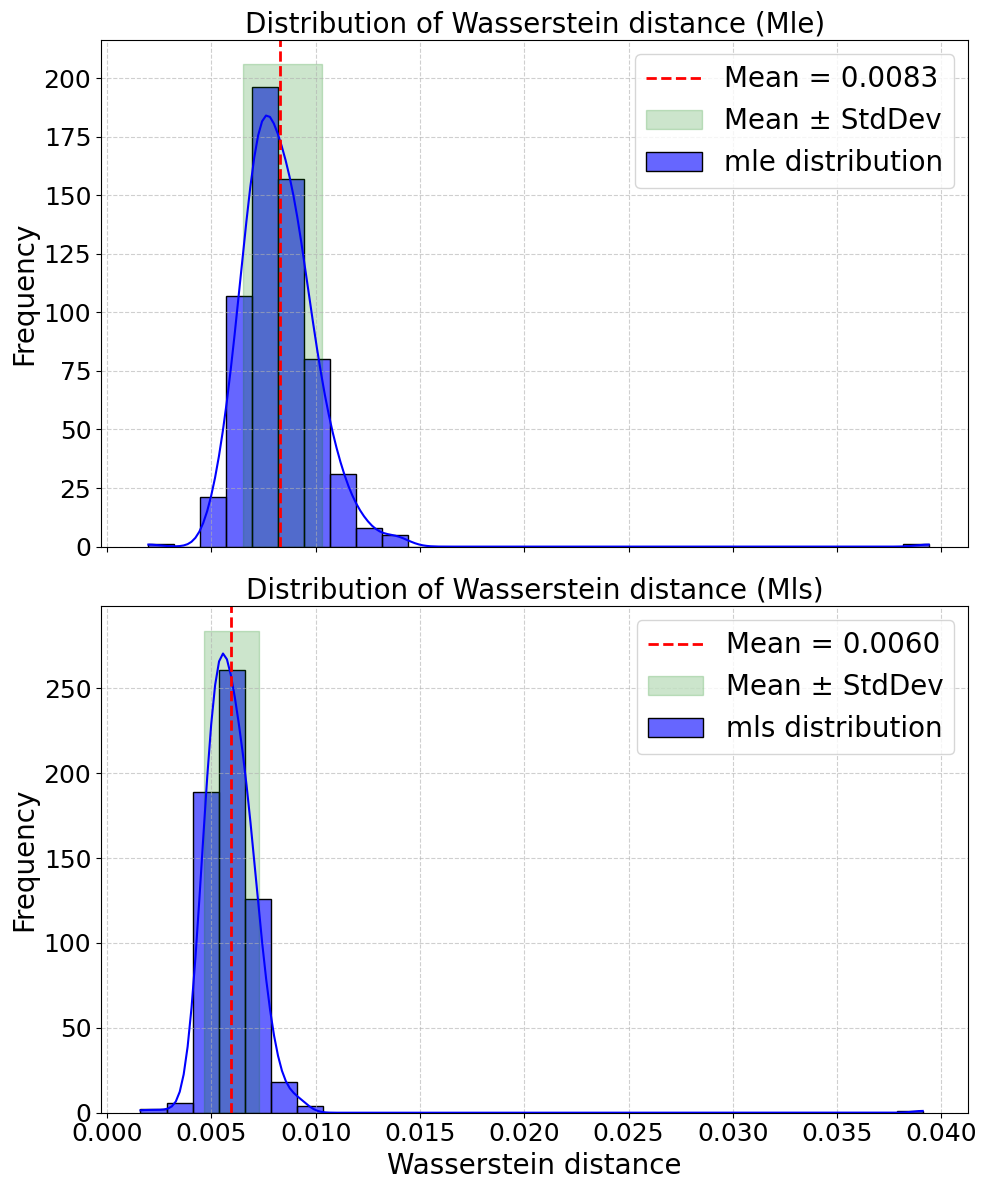

In [25]:
plot_metric_distributions(final_results)

# Modeling results for low and high active consumers 

In [26]:
# List of dates for analysis
dates = ["2018-03-07", "2018-07-26"]

In [27]:
results = []

for date in dates:
    result_df = calc_distr_params(individual, date, model_type='modified')
    if result_df.empty:
        print(f"No data available for {date}. Skipping...")
        continue
    
    mle_params = result_df[result_df['method'] == 'mle'].iloc[0][['B', 'beta', 'x0', 'alpha']].values
    mls_params = result_df[result_df['method'] == 'mls'].iloc[0][['B', 'beta', 'x0', 'alpha']].values
    
    try:
        data = individual.loc[date]
        b = data.apply(lambda x: consumer_acticity(x), axis=1)
        b = b.value_counts(bins=30, normalize=True)
        x_data = np.array([(edge.left + edge.right) / 2 for edge in b.index])
        y_data = np.array(b.values)
        y_data = y_data / np.sum(y_data)
    except Exception as e:
        print(f"Error processing data for {date}: {e}")
        continue
    
    x = np.linspace(0, 6, 1000)
    y_fit_mle = mod_maxwell_boltzmann(x, *mle_params)
    y_fit_mls = mod_maxwell_boltzmann(x, *mls_params)
    
    # Нормализация кривых
    y_fit_mle = normalize_curve(y_fit_mle, y_data)
    y_fit_mls = normalize_curve(y_fit_mls, y_data)
    
    # Сохранение результатов
    results.append({
        'date': date,
        'x_data': x_data,
        'y_data': y_data,
        'y_fit_mle': y_fit_mle,
        'y_fit_mls': y_fit_mls,
        'mle_params': mle_params,
        'mls_params': mls_params
    })

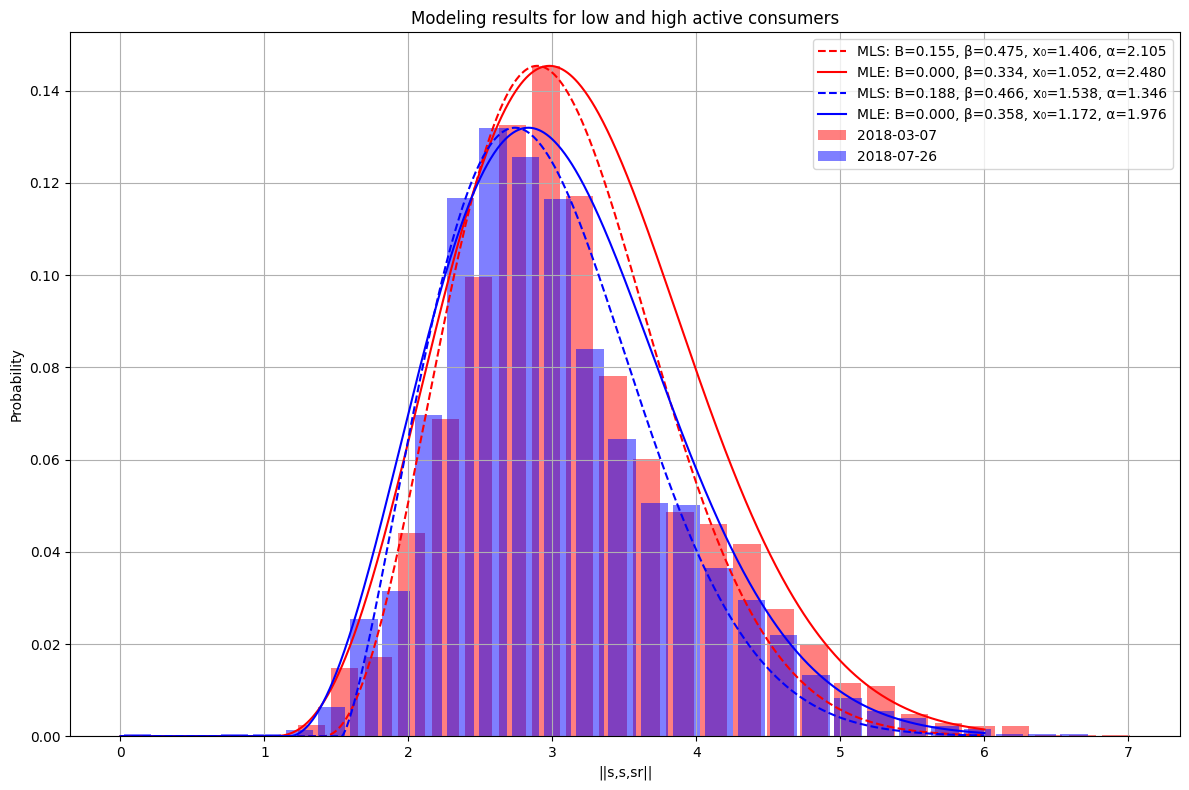

In [28]:
# Plotting a graph
plt.figure(figsize=(12, 8))

for i, res in enumerate(results):
    date = res['date']
    x_data = res['x_data']
    y_data = res['y_data']
    y_fit_mle = res['y_fit_mle']
    y_fit_mls = res['y_fit_mls']
    mle_params = res['mle_params']
    mls_params = res['mls_params']
    if i == 0:
        color = 'red'
    else:
        color = 'blue'
    plt.bar(x_data, y_data, width=0.19, color=color, alpha=0.5, label=f'{date}')
    plt.plot(x, y_fit_mls, ls='--', color=color, label=f'MLS: B={mls_params[0]:.3f}, β={mls_params[1]:.3f}, x₀={mls_params[2]:.3f}, α={mls_params[3]:.3f}')
    plt.plot(x, y_fit_mle, ls='-', color=color, label=f'MLE: B={mle_params[0]:.3f}, β={mle_params[1]:.3f}, x₀={mle_params[2]:.3f}, α={mle_params[3]:.3f}')

plt.xlabel('||s,s,sr||')
plt.ylabel('Probability')
plt.title('Modeling results for low and high active consumers')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()